In [ ]:
#import libraries
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#Connect to drive to access datasets
from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#View one file to see structure
# data = pd.read_csv('/content/drive/MyDrive/AAI511/MODULE3/individual_stocks_5yr/AAPL_data.csv')
data = pd.read_csv('AAPL_data.csv')
data.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
2,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
3,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
4,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL


In [ ]:
#Create a function that takes a file and predicts future stock prices

#Load dataset and remove any Nan values
def Stock_Predict(file):
  url = '/content/drive/MyDrive/AAI511/MODULE3/individual_stocks_5yr/'
  df = pd.read_csv(url+file)
  df = df.dropna()

  #Convert to numpy array and split into training and testing sets
  data = df['close'].values.astype('float32')
  data = np.reshape(data, (len(data), 1))
  train_size = int(len(data) * 0.8)
  test_size = len(data) - train_size
  train_data, test_data = data[0:train_size,:], data[train_size:len(data),:]

  #Normalize the data
  scaler = MinMaxScaler(feature_range=(0, 1))
  train_data = scaler.fit_transform(train_data)
  test_data = scaler.transform(test_data)

  #Create training and testing data and reshape for LSTM
  x_train,y_train = [],[]
  x_test, y_test = [], []

  window_size = 10
  for i in range(window_size, len(train_data)):
      x_train.append(train_data[i-window_size:i, 0])
      y_train.append(train_data[i, 0])

  x_train, y_train = np.array(x_train), np.array(y_train)
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

  for i in range(window_size, len(test_data)):
      x_test.append(test_data[i-window_size:i, 0])
      y_test.append(test_data[i, 0])

  x_test, y_test = np.array(x_test), np.array(y_test)
  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

  #Build the LSTM model, compile, and train
  model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(100, input_shape=(window_size, 1)),
      tf.keras.layers.Dense(1)
  ])

  model.compile(optimizer='adam', loss='mse')
  model.fit(x_train, y_train, epochs=7, batch_size=50, verbose=0)

  #Evaluate and make predications on the test data
  mse = model.evaluate(x_test, y_test)
  predictions = model.predict(x_test)

  rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
  print('Root Mean Squared Error:', round(rmse,2))

  #Denormalize the values
  predictions = scaler.inverse_transform(predictions)
  y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
  y_train = scaler.inverse_transform(y_train.reshape(-1, 1))

  #Create a single prediction given the history of the stock closing price
  single = [test_data[len(test_data) + 1 - window_size:len(test_data + 1), 0]]
  single = np.array(single)
  single = np.reshape(single, (single.shape[0], single.shape[1], 1))
  single_pred = model.predict(single)
  single_pred = scaler.inverse_transform(single_pred)

  #Graph a comparison between the actual values and the predicted values
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
  ax1.plot(y_test, label='Actual')
  ax1.plot(predictions, label='Predicted')
  ax1.set_title('Predicted vs. Actual Closing Price USD($)')
  ax1.set_xlabel('Date')
  ax1.set_ylabel('Close Price USD ($)')
  ax1.legend()

  #Plot the predictions with the historical prices
  train = df[:train_size]
  valid = df[train_size:]
  pred = df[train_size+window_size:]
  pred['Predictions'] = predictions
  ax2.set_title('Model')
  ax2.set_xlabel('Date')
  ax2.set_ylabel('Close Price USD ($)')
  ax2.plot(train['close'])
  ax2.plot(valid['close'])
  ax2.plot(pred['Predictions'])
  ax2.legend(['Train','Pred_acc','Predictions'], loc='lower right')
  plt.show()

  # return single_pred, train_data, test_data

In [ ]:
#Use the AAPL_data.csv file as an example for the dataset after preprocessing
#Used for deliverable 1
# single_pred, train_data, test_data = Stock_Predict('AAPL_data.csv')
# train_data.tofile('/content/drive/MyDrive/AAI511/MODULE3/train_data.csv', sep = ',')
# test_data.tofile('/content/drive/MyDrive/AAI511/MODULE3/test_data.csv', sep = ',')

8/8 [==============================] - 0s 2ms/step
Root Mean Squared Error: 0.21
1/1 [==============================] - 1s 895ms/step


<ipython-input-3-1f409e4a98d6>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred['Predictions'] = predictions


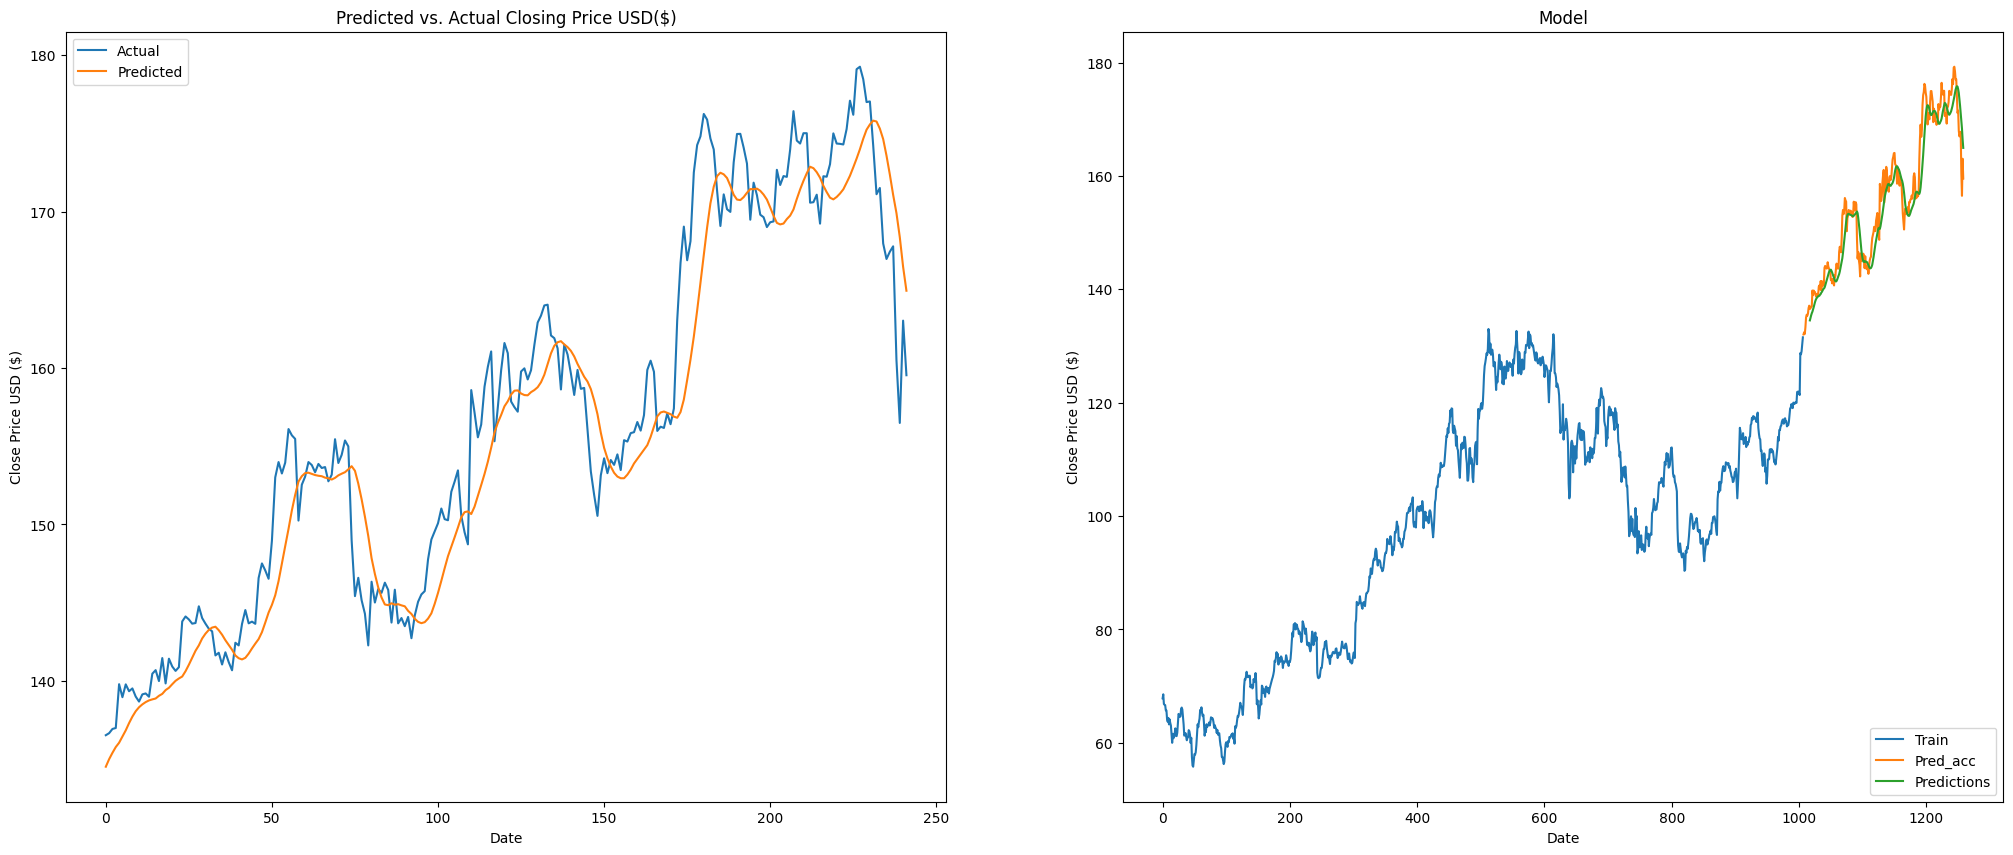

In [ ]:
Stock_Predict('AAPL_data.csv')

8/8 [==============================] - 0s 6ms/step
Root Mean Squared Error: 0.25
1/1 [==============================] - 0s 464ms/step


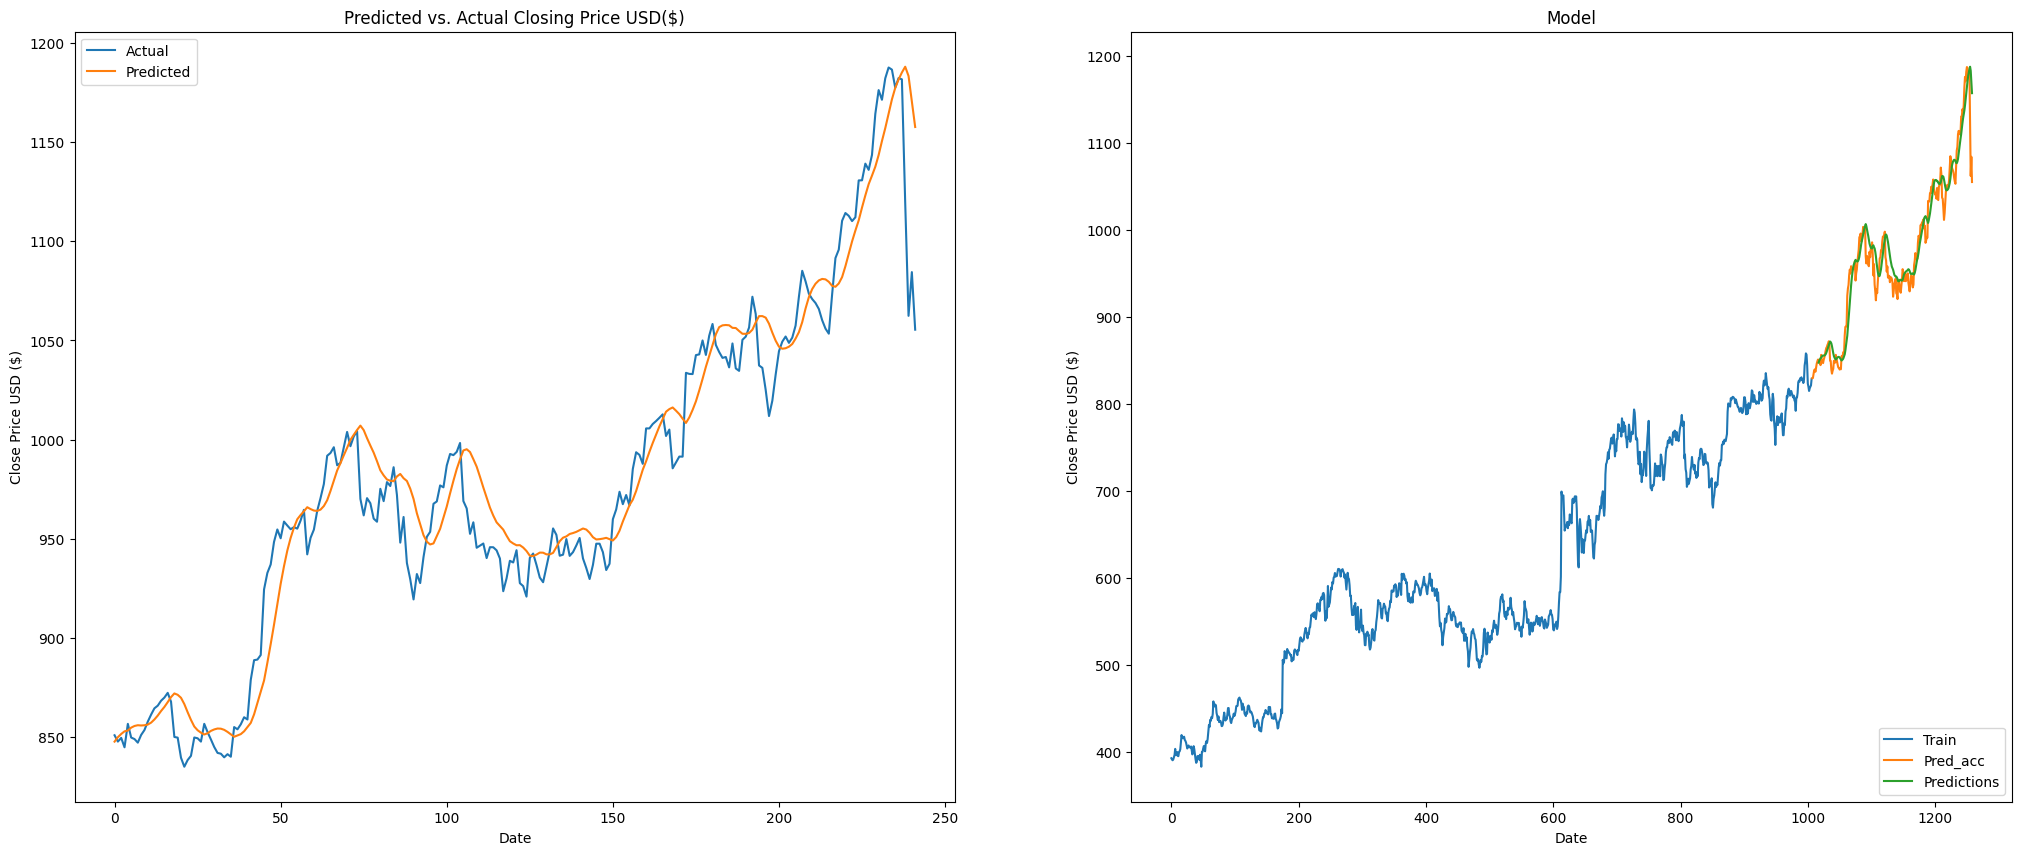

In [ ]:
Stock_Predict('GOOGL_data.csv')

8/8 [==============================] - 1s 5ms/step
Root Mean Squared Error: 0.3
1/1 [==============================] - 0s 456ms/step


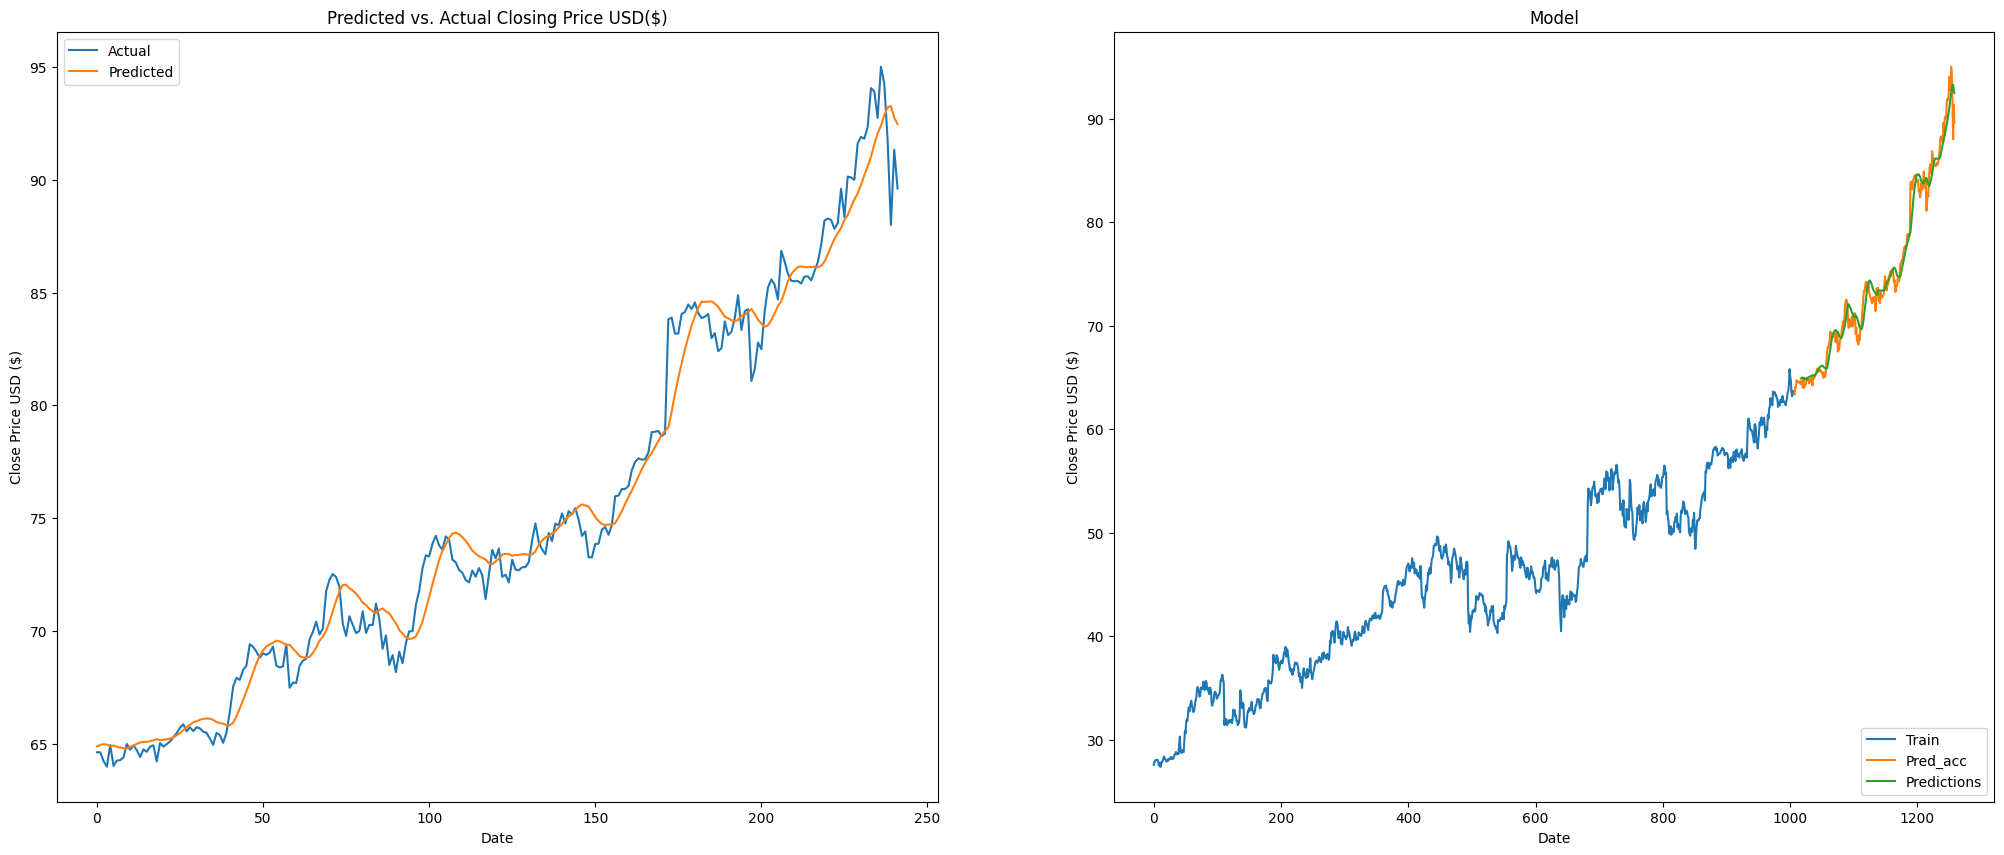

In [ ]:
Stock_Predict('MSFT_data.csv')

In [ ]:
#Select 50 random stocks and predict the stock price given the historical closing prices
#Used for deliverable 3
# import os
# import random
# path = '/content/drive/MyDrive/AAI511/MODULE3/individual_stocks_5yr/'
# dir_list = os.listdir(path)
# dir_list = random.sample(dir_list, 50)

# stock_price_pred = []
# for i in dir_list:
#   single_pred, train_data, test_data = Stock_Predict(i)
#   stock_price_pred.append(single_pred)

# dir_list = np.array(dir_list)
# dir_list.tofile('/content/drive/MyDrive/AAI511/MODULE3/stock_names.csv', sep = ',')
# stock_price_pred = np.array(stock_price_pred)
# stock_price_pred.tofile('/content/drive/MyDrive/AAI511/MODULE3/predictions.csv', sep = ',')
